### Style Transfer

Avalie a mudança de pesos de content e style no arquivo Neural-Style-Transfer/NST.py linha 193.

OBS: O código que foi pedido para ser analisado estava muito com muitos defeitos e não consegui corrigí-los. O disponibilizado pelo monitor também não estava rodando. Então, optei por pegar um código disponibilizado no livro Dive into Deep Learning de uma rede para transferência de estilo e analisar o que foi pedido em cima dela.

In [20]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

Vamos usar essa imagem de dois gatos como imagem de conteúdo e essa pintura de Van Gogh como estilo alvo:

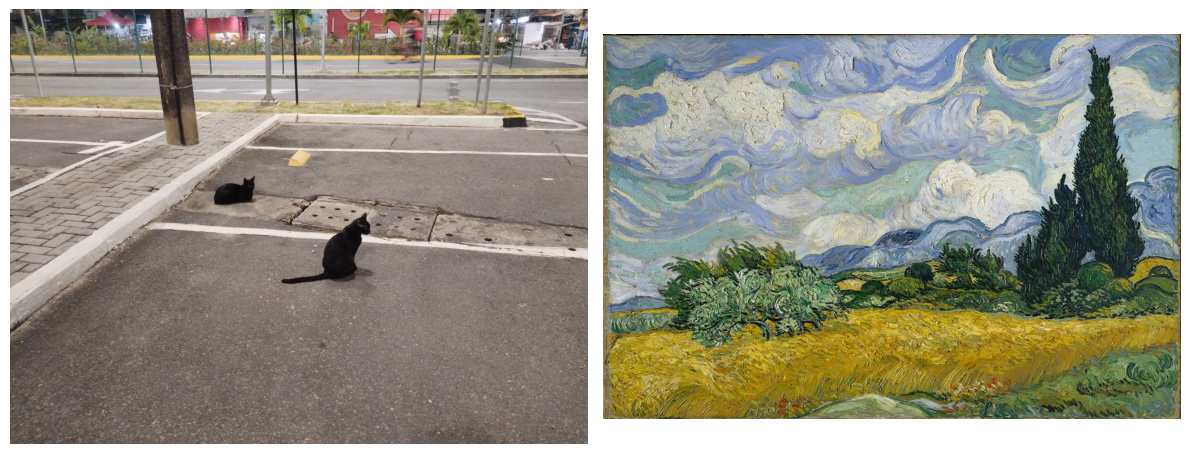

In [75]:
content_img = plt.imread("dvccs_imgs/gatos.jpg")
style_img = plt.imread("dvccs_imgs/Vincent-van-Gogh-Whaet-Field-with-Cypresses.-Image-via-wikimedia.org_.jpg")

content_img = Image.fromarray(content_img)
style_img = Image.fromarray(style_img)


fig, axes = plt.subplots(1, 2, figsize=(12, 13))
axes[0].imshow(content_img)
axes[0].axis('off')

axes[1].imshow(style_img)
axes[1].axis('off')

plt.tight_layout()
plt.show()

Abaixo, o código da rede neural baseada na VGG retirada do livro d2l.ai. Vamos alterá-lo para permitir modificar os pesos de estilo e conteúdo:

In [70]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

pretrained_net = torchvision.models.vgg19(pretrained=True)
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])

def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

def content_loss(Y_hat, Y):
    # We detach the target content from the tree used to dynamically compute
    # the gradient: this is a stated value, not a variable. Otherwise the loss
    # will throw an error.
    return torch.square(Y_hat - Y.detach()).mean()

def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

tv_weight = 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram, content_weight, style_weight):
    # Calculate the content, style, and total variance losses respectively
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # Add up all the losses
    l = sum(styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight
    
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch, content_weight, style_weight):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram, content_weight, style_weight)
        l.backward()
        trainer.step()
        scheduler.step()
    return X

c:\Users\danio\Documents\dev\atv-vcomp-RRIA\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\danio\Documents\dev\atv-vcomp-RRIA\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Vamos realizar o treinamento, variando o peso do conteúdo e do estilo:

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
print(f"Device: {device}")

image_shape = (300, 450)

content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output_1 = train(content_X, contents_Y, styles_Y, device, 0.3, 1000, 50, content_weight=1, style_weight=1e4)
output_2 = train(content_X, contents_Y, styles_Y, device, 0.3, 1000, 50, content_weight=10, style_weight=1e3)
output_3 = train(content_X, contents_Y, styles_Y, device, 0.3, 1000, 50, content_weight=100, style_weight=1e2)

Device: cuda


Transformando os resultados de tensores para arrays numpy e plotando:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-17.4843..11.271088].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1831315..2.255975].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.6887875..5.0487976].


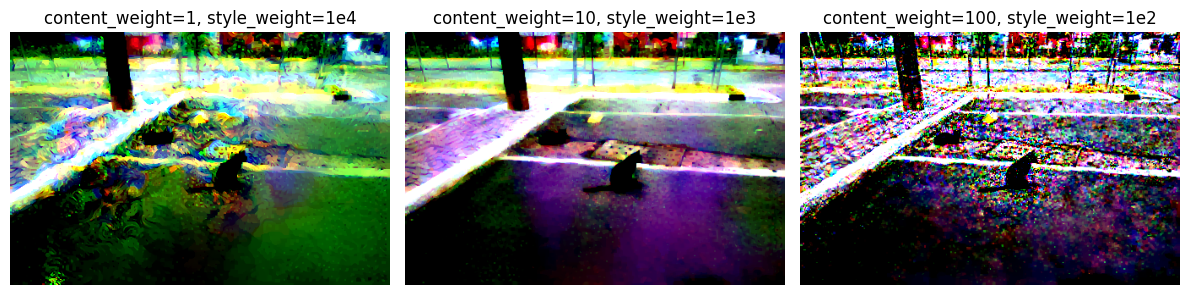

In [79]:
def tensor_to_numpy(tensor):
    output = tensor.detach().cpu()
    output = output.squeeze()
    output = output.permute(1, 2, 0)
    output = output.numpy()
    return output

fig, axes = plt.subplots(1, 3, figsize=(12, 13))

img_1 = tensor_to_numpy(output_1)
img_2 = tensor_to_numpy(output_2)
img_3 = tensor_to_numpy(output_3)

axes[0].imshow(img_1)
axes[0].axis('off')
axes[0].set_title("content_weight=1, style_weight=1e4")

axes[1].imshow(img_2)
axes[1].axis('off')
axes[1].set_title("content_weight=10, style_weight=1e3")

axes[2].imshow(img_3)
axes[2].axis('off')
axes[2].set_title("content_weight=100, style_weight=1e2")

plt.tight_layout()
plt.show()

Apesar de nenhum dos resultados ter ficado muito esteticamente agradável, vemos que é necessário que o peso de estilo seja muito maior que o de conteúdo nesse caso em específico para que obtivéssemos resultados mais interessantes. A primeira imagem de fato começou a mostrar traços semelhantes a pintura de Van Gogh. A do meio ficou mais próxima da original, alterando a textura mas mais principalmente a cor da imagem. Já a terceira, com o peso de conteúdo maior pareceu iniciar uma degeneração da imagem.